In [1]:
from spikeA.Dat_file_reader import Dat_file_reader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_lfp_spectrogram(file_names, start_sample, end_sample, n_channels, channels, sampling_rate = 20000, smoothing=100):
    """
        Method to plot the LFP spectrogram (power vs. frequency)
        
        Arguments:
        file_names: trials to use
        start_sample, end_sample: samples from which and to which to take into account
        n_channels: number of channels in the recording
        channel: channels for which to calculate the spectrogram
        sampling rate: sampling rate of dat file (in Hz)
        smoothing: smoothing of the plot (sigma for Gaussian kernel)
        
        Return:
        frequency, array with convoluted signal for the selected channels        
        """
    
    import numpy as np
    from spikeA.Dat_file_reader import Dat_file_reader
    from scipy.fft import fft, fftfreq
    from scipy.ndimage import gaussian_filter1d
        
    # read the data from the selected dat file for the selected channel
    df = Dat_file_reader(file_names=file_names, n_channels=n_channels)
    data = df.get_data_one_block(start_sample=start_sample, end_sample=end_sample, channels=np.asarray(channels))
    
    # create an array to store the data
    array = np.empty((data.shape[1],len(channels)),float)
    
    # perform a fast Fourier transform
    xf = fftfreq(data.shape[1], 1/sampling_rate)
    for i,j in enumerate(channels):
        data_1_channel = data[i,:]
        yf = fft(data_1_channel)
        
        # smooth with Gaussian kernel
        yf_sm = gaussian_filter1d(np.abs(yf), sigma = smoothing)
        array[:,i]=yf_sm

    return (xf,array)

In [9]:
def detect_theta_peak(xf, yf_sm, theta_range, peak_height, peak_distance):
    """
        Method to find the peak frequency within theta range
        
        Arguments:
        xf: frequency (fft of time)
        yf_sm: smoothed power (fft of signal)
        theta_range: range within the peak should be found
        peak_height: required height for the peak to be detected
        peak_distance: required distance between detected peaks
        
        Return:
        theta peak frequency (in Hz), power at peak frequency    
        """
    
    import numpy as np
    from scipy.signal import find_peaks
    
    theta_signal = yf_sm[xf<theta_range[1]]
    theta_freq = xf[xf<theta_range[1]]
    theta_signal = theta_signal[theta_freq>theta_range[0]]
    theta_freq = theta_freq[theta_freq>theta_range[0]]
    peak = find_peaks(theta_signal, height=peak_height, distance=peak_distance)
    peak_power = int(peak[1].get('peak_heights'))
    peak_freq = (theta_freq[int(peak[0])])

    return (peak_freq,peak_power)

In [3]:
mouse="bt3565"
date="25082021"
name=f"{mouse}-{date}-0105"
path=f"/adata/electro/{mouse}/{name}/"

Get the spectrogram of the first trial from channels 0 and 1.

In [4]:
df = Dat_file_reader(file_names=[f"{path}{mouse}-{date}_01.dat"], n_channels=65)
first, last = df.get_first_last_samples_each_file()
xf,array= plot_lfp_spectrogram(file_names=[f"{path}{mouse}-{date}_01.dat"], start_sample=int(first), end_sample=int(last), n_channels=65, channels=[0,1])

Find the theta peak for channel 0.

In [13]:
yf_sm=array[:,0]
theta_range=[4,10]
peak_distance = xf[xf<theta_range[1]].shape[0]/theta_range[1]/2
peak_height = yf_sm.max()*0.9
peak_freq, peak_power = detect_theta_peak(xf, yf_sm,theta_range,peak_height,peak_distance)

Plot the result.

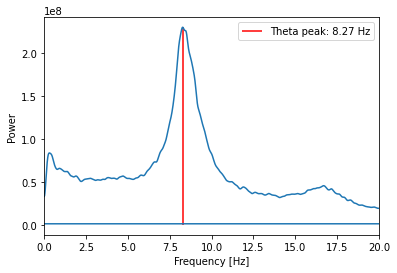

In [19]:
plt.plot(xf, array[:,0])
plt.xlim(0,20)
label = f"Theta peak: {peak_freq:.3} Hz"
plt.vlines(peak_freq, ymin=0, ymax=peak_power, colors='red', label=label)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend()
plt.show()